# Analysis of Placement for Starfruit
Nick & Gio dissagreed on what strategy should be taken when it comes to starfruit, which prompted the creation of this analysis.

Gio: The first approach aims to always beat the worst price in the book by 1$. (order_placement.log)

* PNL = $1918.48


StanfordCardinal: The second approach aims to always to place the worse price between a dollar worse than midprice and a dollar better than worst price. (penalty.log)

* PNL = $1748.80

In [275]:
import sys
sys.path.append('..')
from utils import DataEngine
import pandas as pd

In [276]:
gio = DataEngine.LogInterpreter("../logs/order_placement.log")
stanford = DataEngine.LogInterpreter("../logs/penalty.log")

In [277]:
gio_activities = gio.getActivities(as_df = True).loc[0]
stanford_activities = stanford.getActivities(as_df = True).loc[0]

In [278]:
gio_activities

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,STARFRUIT,5036.0,23.0,NaN,NaN,NaN,NaN,5043.0,23.0,NaN,NaN,NaN,NaN,5039.5,0.000000
100,0,100,STARFRUIT,5042.0,1.0,5039.0,2.0,5037.0,1.0,5043.0,22.0,NaN,NaN,NaN,NaN,5042.5,0.000000
200,0,200,STARFRUIT,5037.0,1.0,5036.0,21.0,NaN,NaN,5043.0,1.0,5044.0,21.0,NaN,NaN,5040.0,2.016113
300,0,300,AMETHYSTS,9995.0,26.0,NaN,NaN,NaN,NaN,10005.0,26.0,NaN,NaN,NaN,NaN,10000.0,5.000000
400,0,400,STARFRUIT,5037.0,28.0,NaN,NaN,NaN,NaN,5044.0,28.0,NaN,NaN,NaN,NaN,5040.5,4.671875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99500,0,99500,STARFRUIT,5049.0,20.0,NaN,NaN,NaN,NaN,5056.0,20.0,NaN,NaN,NaN,NaN,5052.5,1900.535156
99600,0,99600,STARFRUIT,5049.0,28.0,NaN,NaN,NaN,NaN,5056.0,28.0,NaN,NaN,NaN,NaN,5052.5,1901.794922
99700,0,99700,AMETHYSTS,9995.0,26.0,NaN,NaN,NaN,NaN,10005.0,26.0,NaN,NaN,NaN,NaN,10000.0,1827.000000
99800,0,99800,STARFRUIT,5051.0,1.0,5050.0,25.0,NaN,NaN,5057.0,26.0,NaN,NaN,NaN,NaN,5054.0,1915.078125


In [279]:
gio_starfruit_pnl = pd.pivot_table(gio_activities, index = 'timestamp', values = 'profit_and_loss', columns='product').ffill().diff().fillna(0)["STARFRUIT"]
stanford_starfruit_pnl = pd.pivot_table(stanford_activities, index = 'timestamp', values = 'profit_and_loss', columns='product').ffill().diff().fillna(0)["STARFRUIT"]

In [280]:
gio_starfruit_pnl.sum()

1918.4765625

In [281]:
stanford_starfruit_pnl.sum()

1748.796875

<Axes: ylabel='Frequency'>

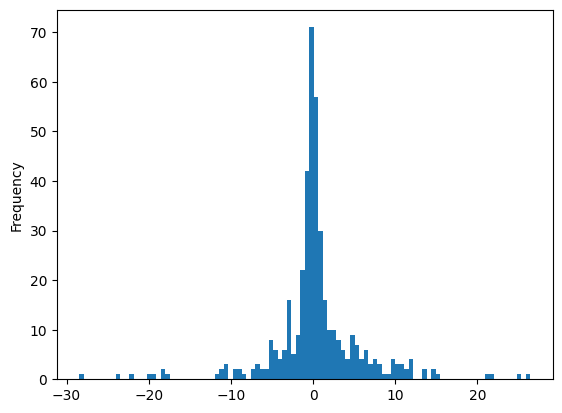

In [282]:
starfruit_diff = (gio_starfruit_pnl - stanford_starfruit_pnl)#.plot(kind="hist")
starfruit_onward_diff = starfruit_diff[::-1].rolling(50).sum()[::-1].fillna(0)
starfruit_diff[starfruit_diff!=0].plot(kind="hist", bins=100)

<Axes: xlabel='timestamp'>

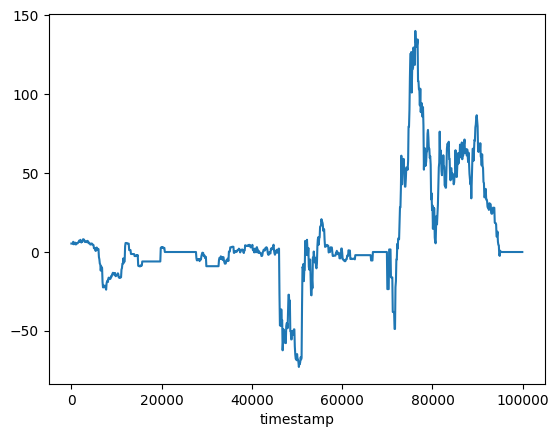

In [283]:
starfruit_onward_diff.plot()

In [284]:
starfruit_diff.describe()

count    1000.000000
mean        0.169680
std         3.598538
min       -28.429688
25%         0.000000
50%         0.000000
75%         0.000000
max        26.445312
Name: STARFRUIT, dtype: float64

### Analysis of the difference

Gio's strategy mostly differs when a 3rd level to the book appears, hence I will use a indicator value to signify when that happens and see how it affects PnL

In [285]:
is_3rd_level = (gio_activities.groupby("timestamp")[["ask_volume_3","bid_volume_3"]].sum().sum(axis=1) > 0).astype(int)
is_3rd_level

timestamp
0        0
100      1
200      0
300      0
400      0
        ..
99500    0
99600    0
99700    0
99800    0
99900    0
Length: 1000, dtype: int64

In [286]:
df = is_3rd_level
df = df.to_frame("is_3rd_level")
df["pnl_diff"] = starfruit_diff
df["pnl_onward_diff"] = starfruit_onward_diff

In [287]:
from sklearn.linear_model import LinearRegression

In [288]:
LinearRegression().fit(df[["is_3rd_level"]], df[["pnl_onward_diff"]]).coef_

array([[0.3952094]])

In [289]:
pnl_vs_time = []
for i in range(1, 100):
    df[f"pnl_onward_diff_{i}"] = starfruit_diff[::-1].rolling(i).sum()[::-1].fillna(0)
    pnl_vs_time += [LinearRegression(fit_intercept=True).fit(df[["is_3rd_level"]], df[[f"pnl_onward_diff_{i}"]]).coef_[0][0]]

In [290]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Holding Time')

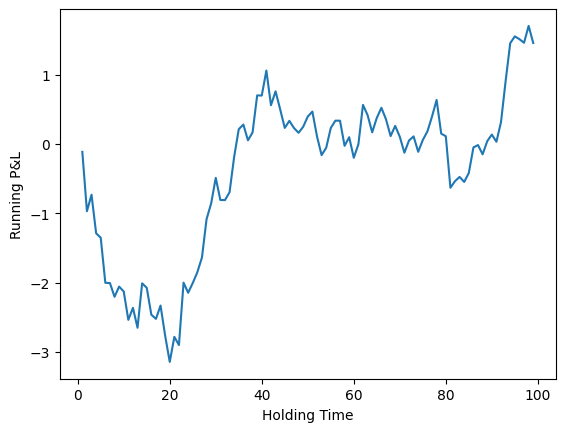

In [291]:
plt.plot(range(1, 100), pnl_vs_time)
plt.ylabel("Running P&L")
plt.xlabel("Holding Time")

In [292]:
is_3rd_level.sum()/len(is_3rd_level)

0.181

### Another interesting idea

Does the existance of the third level imply that the other levels will get blown?

In [295]:
midprice_starfruit = (gio_activities.loc[gio_activities["product"] == "STARFRUIT"].bid_price_1 + gio_activities.loc[gio_activities["product"] == "STARFRUIT"].ask_price_1)/2

In [296]:
midprice_starfruit_diff_shift = midprice_starfruit.diff().shift(-1).iloc[:-2]

In [297]:
midprice_starfruit_diff_shift

0        3.0
100     -2.5
200      0.5
400     -1.0
500      3.0
        ... 
99100    0.0
99200   -0.5
99400   -0.5
99500    0.0
99600    1.5
Length: 622, dtype: float64

In [332]:
ask3_exists = (gio_activities[["ask_volume_3"]] > 0).astype(int).iloc[:-2]
bid3_exists = (gio_activities[["bid_volume_3"]] > 0).astype(int).iloc[:-2]
askbid3_exists = pd.concat([ask3_exists, bid3_exists], axis=1)
askbid3_exists["price_diff"] = midprice_starfruit_diff_shift.fillna(0)

In [333]:
(gio_activities[["ask_volume_2"]] > 0)

,ask_volume_2
0,False
100,False
200,True
300,False
400,False
...,...
99500,False
99600,False
99700,False
99800,False


In [334]:
ask3_exists.sum()

ask_volume_3    98
dtype: int64

In [335]:
midprice_starfruit_diff_shift = askbid3_exists.pop("price_diff")

In [337]:
LinearRegression(fit_intercept=True).fit(askbid3_exists, midprice_starfruit_diff_shift).coef_

array([ 0.34500724, -0.56911361])

In [338]:
midprice_starfruit_diff_shift.mean()

0.014529058116232466

### On a different note

Let's verify how the presence of lvl2 without lvl3 affect the price

In [341]:
ask3_exists = ((gio_activities["ask_volume_2"] > 0) & (gio_activities["ask_volume_3"].isna())).astype(int).iloc[:-2]
bid3_exists = ((gio_activities["bid_volume_2"] > 0) & (gio_activities["bid_volume_3"].isna())).astype(int).iloc[:-2]
askbid3_exists = pd.concat([ask3_exists, bid3_exists], axis=1)
askbid3_exists["price_diff"] = midprice_starfruit_diff_shift.fillna(0)

In [342]:
midprice_starfruit_diff_shift = askbid3_exists.pop("price_diff")

In [343]:
LinearRegression(fit_intercept=True).fit(askbid3_exists, midprice_starfruit_diff_shift).coef_

array([ 0.61731098, -0.47699895])